# Understanding Vector Embeddings

This notebook explains how text is converted into numerical representations (vectors) that machines can understand and process.

## Journey from Text to Semantic Embeddings

We'll explore:
1. **Tokenization & Chunking** - Breaking text into pieces
2. **Basic Encodings** - Binary, One-Hot, Multi-Hot (Bag of Words)
3. **Why Basic Encodings Fail** - The semantic gap
4. **Dense Embeddings** - Continuous vectors that capture meaning
5. **Practical Examples** - Using Sentence Transformers and Mistral
6. **Visualization** - Heatmaps showing semantic relationships

---

In [1]:
# Install required packages
! pip install sentence-transformers mistralai python-dotenv matplotlib seaborn numpy scikit-learn pandas -q
! pip uninstall numpy -y
! pip install numpy==1.26.4

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
streamlit 1.50.0 requires pillow<12,>=7.1.0, but you have pillow 12.0.0 which is incompatible.

[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


Found existing installation: numpy 2.3.4
Uninstalling numpy-2.3.4:
  Successfully uninstalled numpy-2.3.4


You can safely remove it manually.
You can safely remove it manually.


     ---------------------------------------- 0.0/15.8 MB ? eta -:--:--
     ---------------------------------------- 0.0/15.8 MB ? eta -:--:--
     ---------------------------------------- 0.0/15.8 MB ? eta -:--:--
      --------------------------------------- 0.3/15.8 MB ? eta -:--:--
      --------------------------------------- 0.3/15.8 MB ? eta -:--:--
      --------------------------------------- 0.3/15.8 MB ? eta -:--:--
      --------------------------------------- 0.3/15.8 MB ? eta -:--:--
      --------------------------------------- 0.3/15.8 MB ? eta -:--:--
     - ------------------------------------- 0.5/15.8 MB 261.3 kB/s eta 0:00:59
     - ------------------------------------- 0.5/15.8 MB 261.3 kB/s eta 0:00:59
     - ------------------------------------- 0.5/15.8 MB 261.3 kB/s eta 0:00:59
     - ------------------------------------- 0.5/15.8 MB 261.3 kB/s eta 0:00:59
     - ------------------------------------- 0.8/15.8 MB 273.6 kB/s eta 0:00:55
     - -----------------


[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
# Import libraries
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from dotenv import load_dotenv
from sentence_transformers import SentenceTransformer
from mistralai import Mistral
from sklearn.metrics.pairwise import cosine_similarity
import warnings
warnings.filterwarnings('ignore')

# Setup plotting style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

print("✓ All libraries imported successfully!")

d:\IOT Work\Outskill\GenAIEngineering-Cohort3\GenAIEngineering-Cohort3\outskills git hub repostry\GenAIEngineering-Cohort3\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


✓ All libraries imported successfully!


---

## Part 1: Tokenization and Text Chunking

Before we can encode text, we need to break it down into smaller units called **tokens**.

### What is Tokenization?

Tokenization is the process of splitting text into smaller pieces (tokens). These can be:
- **Words**: "Hello world" → ["Hello", "world"]
- **Subwords**: "unhappiness" → ["un", "happiness"]
- **Characters**: "Hi" → ["H", "i"]

### What is Chunking?

Chunking divides long documents into smaller, manageable pieces while preserving meaning.

In [3]:
print("=" * 80)
print("TOKENIZATION EXAMPLES")
print("=" * 80)

sample_text = "Machine learning is transforming artificial intelligence!"

# Word tokenization (simple)
words = sample_text.split()
print(f"\nOriginal text: {sample_text}")
print(f"\nWord Tokens: {words}")
print(f"Number of tokens: {len(words)}")

# Character tokenization
chars = list(sample_text)
print(f"\nCharacter Tokens: {chars[:20]}...")
print(f"Number of character tokens: {len(chars)}")

# Subword tokenization (simulated)
complex_word = "unhappiness"
subwords = ["un", "happi", "ness"]
print(f"\nSubword Example: '{complex_word}' → {subwords}")
print("\nℹ️  Modern LLMs use sophisticated subword tokenizers (BPE, WordPiece, etc.)")

TOKENIZATION EXAMPLES

Original text: Machine learning is transforming artificial intelligence!

Word Tokens: ['Machine', 'learning', 'is', 'transforming', 'artificial', 'intelligence!']
Number of tokens: 6

Character Tokens: ['M', 'a', 'c', 'h', 'i', 'n', 'e', ' ', 'l', 'e', 'a', 'r', 'n', 'i', 'n', 'g', ' ', 'i', 's', ' ']...
Number of character tokens: 57

Subword Example: 'unhappiness' → ['un', 'happi', 'ness']

ℹ️  Modern LLMs use sophisticated subword tokenizers (BPE, WordPiece, etc.)


In [4]:
print("\n" + "=" * 80)
print("TEXT CHUNKING EXAMPLES")
print("=" * 80)

long_document = """Artificial intelligence is revolutionizing many industries. 
Machine learning enables computers to learn from data without explicit programming. 
Deep learning uses neural networks with multiple layers to process information. 
Natural language processing helps computers understand human language. 
Computer vision allows machines to interpret and analyze visual information."""

def simple_chunk(text, chunk_size=100, overlap=20):
    """Split text into overlapping chunks by character count."""
    chunks = []
    start = 0
    while start < len(text):
        end = start + chunk_size
        chunk = text[start:end]
        chunks.append(chunk.strip())
        start += chunk_size - overlap
    return chunks

chunks = simple_chunk(long_document, chunk_size=100, overlap=20)

print(f"\nOriginal document length: {len(long_document)} characters")
print(f"Number of chunks: {len(chunks)}\n")

for i, chunk in enumerate(chunks, 1):
    print(f"Chunk {i} ({len(chunk)} chars): {chunk[:80]}...")

print("\nℹ️  Overlap helps maintain context between chunks")


TEXT CHUNKING EXAMPLES

Original document length: 375 characters
Number of chunks: 5

Chunk 1 (100 chars): Artificial intelligence is revolutionizing many industries. 
Machine learning en...
Chunk 2 (100 chars): ables computers to learn from data without explicit programming. 
Deep learning ...
Chunk 3 (100 chars): uses neural networks with multiple layers to process information. 
Natural langu...
Chunk 4 (100 chars): age processing helps computers understand human language. 
Computer vision allow...
Chunk 5 (55 chars): s machines to interpret and analyze visual information....

ℹ️  Overlap helps maintain context between chunks


---

## Part 2: Basic Encoding Methods

Now that we have tokens, we need to convert them to numbers. Let's explore different approaches.

### 2.1 One-Hot Encoding

Each word is represented as a vector with all zeros except one position.

**Key Idea**: Use vector dimensions as identifiers - each word gets its own dimension.

ONE-HOT ENCODING

Vocabulary size: 5
Each word is represented by a 5-dimensional vector

One-Hot Vectors:
----------------------------------------
cat      → [1 0 0 0 0]
dog      → [0 1 0 0 0]
bird     → [0 0 1 0 0]
fish     → [0 0 0 1 0]
rabbit   → [0 0 0 0 1]


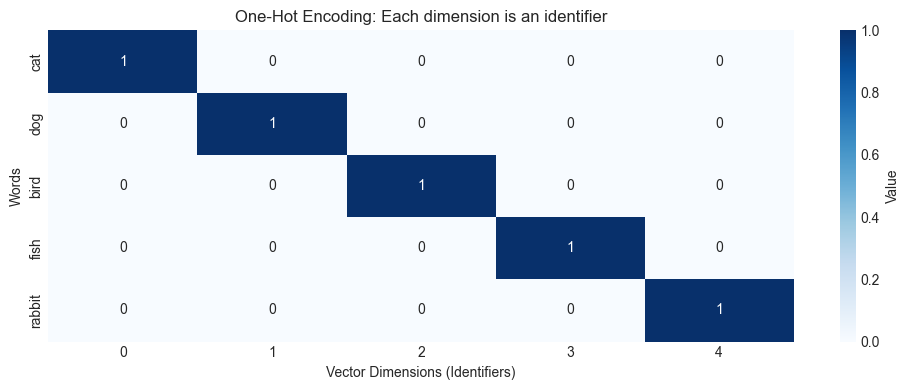


⚠️  PROBLEMS with One-Hot Encoding:
  • High dimensionality: Need one dimension per unique word
  • Sparse vectors: Mostly zeros, wastes memory
  • No semantic relationships: All words equally distant
  • Doesn't scale: 10K vocabulary → 10K dimensions

📊 Similarity:
  cat ↔ dog  (both animals): 0.000
  cat ↔ bird (both animals): 0.000
  → All pairs have same similarity (0.0) - no semantic info!


In [5]:
print("=" * 80)
print("ONE-HOT ENCODING")
print("=" * 80)

vocabulary = ["cat", "dog", "bird", "fish", "rabbit"]
vocab_size = len(vocabulary)

print(f"\nVocabulary size: {vocab_size}")
print(f"Each word is represented by a {vocab_size}-dimensional vector\n")

# Create one-hot vectors
one_hot_vectors = {}
for idx, word in enumerate(vocabulary):
    vector = np.zeros(vocab_size, dtype=int)
    vector[idx] = 1
    one_hot_vectors[word] = vector

print("One-Hot Vectors:")
print("-" * 40)
for word, vector in one_hot_vectors.items():
    print(f"{word:8} → {vector}")

# Visualize
fig, ax = plt.subplots(figsize=(10, 4))
vectors_matrix = np.array([one_hot_vectors[w] for w in vocabulary])
sns.heatmap(vectors_matrix, annot=True, fmt='d', cmap='Blues', 
            xticklabels=range(vocab_size), yticklabels=vocabulary,
            cbar_kws={'label': 'Value'}, ax=ax)
ax.set_xlabel('Vector Dimensions (Identifiers)')
ax.set_ylabel('Words')
ax.set_title('One-Hot Encoding: Each dimension is an identifier')
plt.tight_layout()
plt.show()

print("\n⚠️  PROBLEMS with One-Hot Encoding:")
print("  • High dimensionality: Need one dimension per unique word")
print("  • Sparse vectors: Mostly zeros, wastes memory")
print("  • No semantic relationships: All words equally distant")
print("  • Doesn't scale: 10K vocabulary → 10K dimensions")

# Demonstrate no semantic relationship
cat_vec = one_hot_vectors["cat"]
dog_vec = one_hot_vectors["dog"]
bird_vec = one_hot_vectors["bird"]

similarity_cat_dog = cosine_similarity([cat_vec], [dog_vec])[0][0]
similarity_cat_bird = cosine_similarity([cat_vec], [bird_vec])[0][0]

print(f"\n📊 Similarity:")
print(f"  cat ↔ dog  (both animals): {similarity_cat_dog:.3f}")
print(f"  cat ↔ bird (both animals): {similarity_cat_bird:.3f}")
print("  → All pairs have same similarity (0.0) - no semantic info!")


### 2.2 Binary Encoding

Assign each unique token a unique binary number.


In [6]:
print("=" * 80)
print("BINARY ENCODING")
print("=" * 80)

vocabulary = ["cat", "dog", "bird", "fish", "rabbit"]

print("\nVocabulary:", vocabulary)
print("\nBinary Encoding (as identifiers):")
print("-" * 40)

for idx, word in enumerate(vocabulary):
    binary = format(idx, '03b')  # 3-bit binary
    print(f"{word:8} → {idx} → {binary}")

print("\n⚠️  PROBLEMS with Binary Encoding:")
print("  • Numbers imply order: 'cat'(0) < 'dog'(1) < 'bird'(2)")
print("  • Arithmetic relationships: dog - cat = 1 (meaningless!)")
print("  • No semantic information captured")
print("  • 'cat' and 'dog' are as different as 'cat' and 'bird'")

BINARY ENCODING

Vocabulary: ['cat', 'dog', 'bird', 'fish', 'rabbit']

Binary Encoding (as identifiers):
----------------------------------------
cat      → 0 → 000
dog      → 1 → 001
bird     → 2 → 010
fish     → 3 → 011
rabbit   → 4 → 100

⚠️  PROBLEMS with Binary Encoding:
  • Numbers imply order: 'cat'(0) < 'dog'(1) < 'bird'(2)
  • Arithmetic relationships: dog - cat = 1 (meaningless!)
  • No semantic information captured
  • 'cat' and 'dog' are as different as 'cat' and 'bird'


### 2.3 Multi-Hot Encoding (Bag of Words)

For sentences/documents: Multiple positions can be 1 (sum of one-hot vectors).

**Used for**: Document representation, but still loses semantic meaning.

MULTI-HOT ENCODING (BAG OF WORDS)

Vocabulary: ['cat', 'dog', 'bird', 'fish', 'rabbit', 'runs', 'flies', 'swims', 'jumps']
Vocabulary size: 9

Multi-Hot Vectors (with word counts):

cat runs             → [1 0 0 0 0 1 0 0 0]
bird flies           → [0 0 1 0 0 0 1 0 0]
fish swims           → [0 0 0 1 0 0 0 1 0]
dog runs and jumps   → [0 1 0 0 0 1 0 0 1]
cat and dog          → [1 1 0 0 0 0 0 0 0]


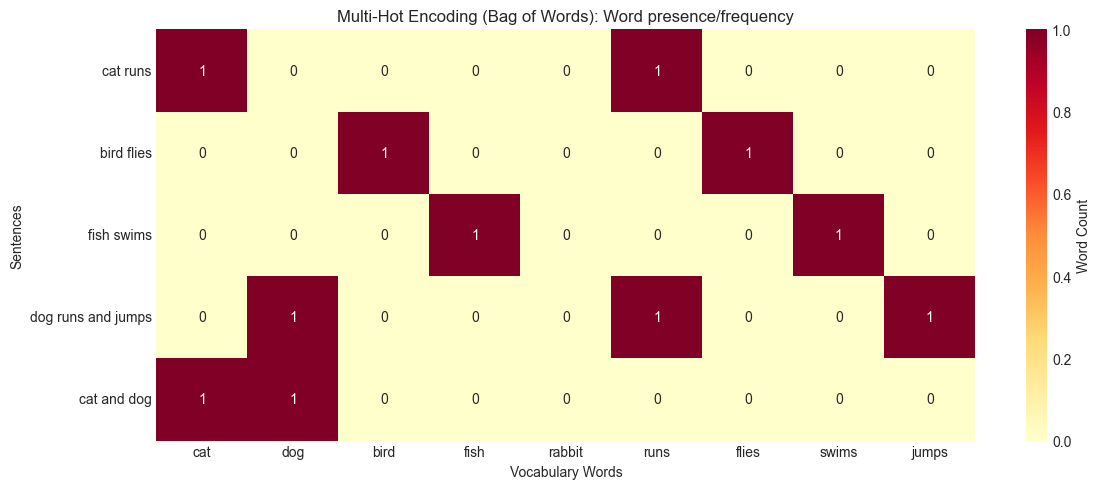


⚠️  PROBLEMS with Multi-Hot Encoding:
  • Loses word order: 'dog bites man' = 'man bites dog'
  • Still no semantics: 'cat' and 'dog' still have no relationship
  • Sparse and high-dimensional
  • Cannot handle synonyms: 'happy' and 'joyful' are unrelated


In [7]:
print("=" * 80)
print("MULTI-HOT ENCODING (BAG OF WORDS)")
print("=" * 80)

# Expanded vocabulary
vocabulary = ["cat", "dog", "bird", "fish", "rabbit", "runs", "flies", "swims", "jumps"]
vocab_size = len(vocabulary)
word_to_idx = {word: idx for idx, word in enumerate(vocabulary)}

print(f"\nVocabulary: {vocabulary}")
print(f"Vocabulary size: {vocab_size}\n")

# Example sentences
sentences = [
    "cat runs",
    "bird flies",
    "fish swims",
    "dog runs and jumps",
    "cat and dog"
]

def multi_hot_encode(sentence, word_to_idx, vocab_size):
    """Convert sentence to multi-hot vector."""
    vector = np.zeros(vocab_size, dtype=int)
    words = sentence.lower().split()
    for word in words:
        if word in word_to_idx:
            vector[word_to_idx[word]] += 1  # Can count frequency
    return vector

print("Multi-Hot Vectors (with word counts):\n")
multi_hot_vectors = []
for sentence in sentences:
    vector = multi_hot_encode(sentence, word_to_idx, vocab_size)
    multi_hot_vectors.append(vector)
    print(f"{sentence:20} → {vector}")

# Visualize
fig, ax = plt.subplots(figsize=(12, 5))
vectors_matrix = np.array(multi_hot_vectors)
sns.heatmap(vectors_matrix, annot=True, fmt='d', cmap='YlOrRd', 
            xticklabels=vocabulary, yticklabels=sentences,
            cbar_kws={'label': 'Word Count'}, ax=ax)
ax.set_xlabel('Vocabulary Words')
ax.set_ylabel('Sentences')
ax.set_title('Multi-Hot Encoding (Bag of Words): Word presence/frequency')
plt.tight_layout()
plt.show()

print("\n⚠️  PROBLEMS with Multi-Hot Encoding:")
print("  • Loses word order: 'dog bites man' = 'man bites dog'")
print("  • Still no semantics: 'cat' and 'dog' still have no relationship")
print("  • Sparse and high-dimensional")
print("  • Cannot handle synonyms: 'happy' and 'joyful' are unrelated")

---

## Part 3: Why We Need Dense Embeddings

### The Key Insight: Continuous Numbers Can Encode Semantics

Instead of discrete identifiers (0 or 1), we use **continuous real numbers** in **lower dimensions** to capture meaning.

**Example**: Instead of 10,000 dimensions with mostly zeros, use 384 dimensions with meaningful numbers.

### Properties of Dense Embeddings:

1. **Lower dimensionality**: 384-1536 dimensions vs. 10,000+
2. **Dense**: All values are non-zero meaningful numbers
3. **Semantic**: Similar meanings → similar vectors
4. **Continuous**: Smooth transitions in meaning space

### How it works:

Each dimension captures a **latent semantic feature**:
- Dimension 1: "animal-ness"
- Dimension 2: "size"
- Dimension 3: "domestic vs. wild"
- ... and so on

The **magnitude** of the number in each dimension indicates how much that feature applies.

COMPARISON: One-Hot vs Dense Embeddings


      Feature                     One-Hot        Dense Embeddings
   Dimensions Vocabulary size (10K-100K+)        Fixed (384-1536)
     Sparsity  Very sparse (99.99% zeros) Dense (all values used)
Semantic Info                        None   Rich semantic meaning
Similar words         All equally distant   Close in vector space
 Memory Usage           High (but sparse)                   Lower
  Computation                 Inefficient               Efficient


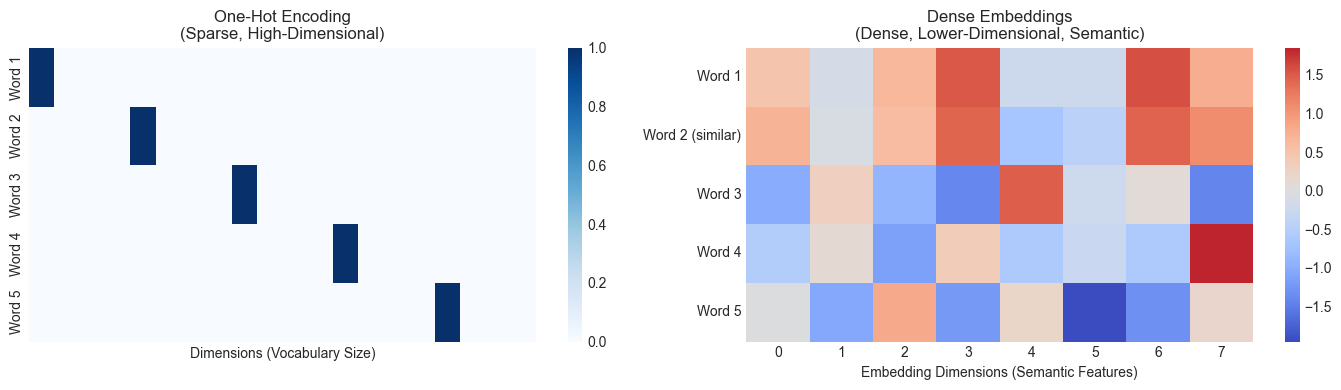


✅ Dense Embeddings solve all the problems:
  • Lower dimensional (384 vs 10,000+)
  • Capture semantic similarity
  • Continuous values encode meaning
  • Efficient computation and storage


In [8]:
print("=" * 80)
print("COMPARISON: One-Hot vs Dense Embeddings")
print("=" * 80)

# Create comparison table
comparison = pd.DataFrame({
    'Feature': [
        'Dimensions',
        'Sparsity',
        'Semantic Info',
        'Similar words',
        'Memory Usage',
        'Computation'
    ],
    'One-Hot': [
        'Vocabulary size (10K-100K+)',
        'Very sparse (99.99% zeros)',
        'None',
        'All equally distant',
        'High (but sparse)',
        'Inefficient'
    ],
    'Dense Embeddings': [
        'Fixed (384-1536)',
        'Dense (all values used)',
        'Rich semantic meaning',
        'Close in vector space',
        'Lower',
        'Efficient'
    ]
})

print("\n")
print(comparison.to_string(index=False))

# Visualize dimensionality difference
fig, axes = plt.subplots(1, 2, figsize=(14, 4))

# One-Hot (sparse)
one_hot_example = np.zeros((5, 20))
for i in range(5):
    one_hot_example[i, i*4] = 1

sns.heatmap(one_hot_example, ax=axes[0], cmap='Blues', cbar=True,
            xticklabels=False, yticklabels=['Word 1', 'Word 2', 'Word 3', 'Word 4', 'Word 5'])
axes[0].set_title('One-Hot Encoding\n(Sparse, High-Dimensional)')
axes[0].set_xlabel('Dimensions (Vocabulary Size)')

# Dense embeddings
np.random.seed(42)
dense_example = np.random.randn(5, 8)  # Much fewer dimensions
dense_example[1] = dense_example[0] + np.random.randn(8) * 0.3  # Make similar

sns.heatmap(dense_example, ax=axes[1], cmap='coolwarm', center=0, cbar=True,
            xticklabels=range(8), yticklabels=['Word 1', 'Word 2 (similar)', 'Word 3', 'Word 4', 'Word 5'])
axes[1].set_title('Dense Embeddings\n(Dense, Lower-Dimensional, Semantic)')
axes[1].set_xlabel('Embedding Dimensions (Semantic Features)')

plt.tight_layout()
plt.show()

print("\n✅ Dense Embeddings solve all the problems:")
print("  • Lower dimensional (384 vs 10,000+)")
print("  • Capture semantic similarity")
print("  • Continuous values encode meaning")
print("  • Efficient computation and storage")

---

## Part 4: Dense Embeddings with Sentence Transformers

Now let's see real dense embeddings in action using the open-source **Sentence Transformers** library.

We'll use a small model that produces **32-dimensional embeddings** for visualization purposes.

In [9]:
print("=" * 80)
print("LOADING SENTENCE TRANSFORMER MODEL")
print("=" * 80)

# Load a small model for demonstration
# Note: For production, use larger models like 'all-MiniLM-L6-v2' (384 dims)
model_name = 'sentence-transformers/all-MiniLM-L6-v2'
print(f"\nLoading model: {model_name}")
print("This may take a moment on first run...\n")

st_model = SentenceTransformer(model_name)

print(f"✓ Model loaded!")
print(f"Embedding dimension: {st_model.get_sentence_embedding_dimension()}")

LOADING SENTENCE TRANSFORMER MODEL

Loading model: sentence-transformers/all-MiniLM-L6-v2
This may take a moment on first run...



Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


✓ Model loaded!
Embedding dimension: 384


In [10]:
print("\n" + "=" * 80)
print("GENERATING EMBEDDINGS FOR 5 DIFFERENT SUBJECTS")
print("=" * 80)

# 5 sentences from different domains
sentences = [
    "The cat sat on the mat and purred contentedly.",  # Animals/Pets
    "Machine learning algorithms process vast amounts of data.",  # Technology/AI
    "The doctor examined the patient's symptoms carefully.",  # Medical/Healthcare
    "the blood pressure is normal.",
    "The stock market experienced significant volatility today.",  # Finance/Economics
    "The chef prepared a delicious Italian pasta dish.",  # Food/Cooking
    "The indian cuisine is spicy and full of flavor."  # Food/Cooking

]

topics = ["Animals", "Technology", "Medical", "Medical", "Finance", "Food", "Food"]

print("\nSentences to embed:\n")
for i, (topic, sentence) in enumerate(zip(topics, sentences), 1):
    print(f"{i}. [{topic}] {sentence}")

# Generate embeddings
print("\nGenerating embeddings...")
embeddings = st_model.encode(sentences)

print(f"\n✓ Generated embeddings!")
print(f"Shape: {embeddings.shape}")
print(f"  • {embeddings.shape[0]} sentences")
print(f"  • {embeddings.shape[1]} dimensions per embedding")


GENERATING EMBEDDINGS FOR 5 DIFFERENT SUBJECTS

Sentences to embed:

1. [Animals] The cat sat on the mat and purred contentedly.
2. [Technology] Machine learning algorithms process vast amounts of data.
3. [Medical] The doctor examined the patient's symptoms carefully.
4. [Medical] the blood pressure is normal.
5. [Finance] The stock market experienced significant volatility today.
6. [Food] The chef prepared a delicious Italian pasta dish.
7. [Food] The indian cuisine is spicy and full of flavor.

Generating embeddings...

✓ Generated embeddings!
Shape: (7, 384)
  • 7 sentences
  • 384 dimensions per embedding


In [11]:
# Reduce to 32 dimensions for visualization
from sklearn.decomposition import PCA

print("\n" + "=" * 80)
print("REDUCING TO 32 DIMENSIONS FOR VISUALIZATION")
print("=" * 80)

# Reduce dimensions for visualization
pca = PCA(n_components=5)
embeddings_32d = pca.fit_transform(embeddings)

print(f"\nReduced from {embeddings.shape[1]}D to 32D")
print(f"Variance explained: {pca.explained_variance_ratio_.sum():.2%}")

# Show first few dimensions for one embedding
print(f"\nExample: First 10 dimensions of '{topics[0]}' embedding:")
print(embeddings_32d[0][:10])
print("\nℹ️  Each number captures semantic features (continuous, not binary!)")


REDUCING TO 32 DIMENSIONS FOR VISUALIZATION

Reduced from 384D to 32D
Variance explained: 88.10%

Example: First 10 dimensions of 'Animals' embedding:
[-0.02404307 -0.68260735 -0.412469    0.06208023 -0.44898418]

ℹ️  Each number captures semantic features (continuous, not binary!)


### 4.1 Visualizing Embeddings with Heatmap

Each row is a sentence, each column is a dimension. The **color intensity** shows the magnitude of the number in that dimension - indicating how much that semantic feature applies.

HEATMAP: Embedding Vectors (32 Dimensions)


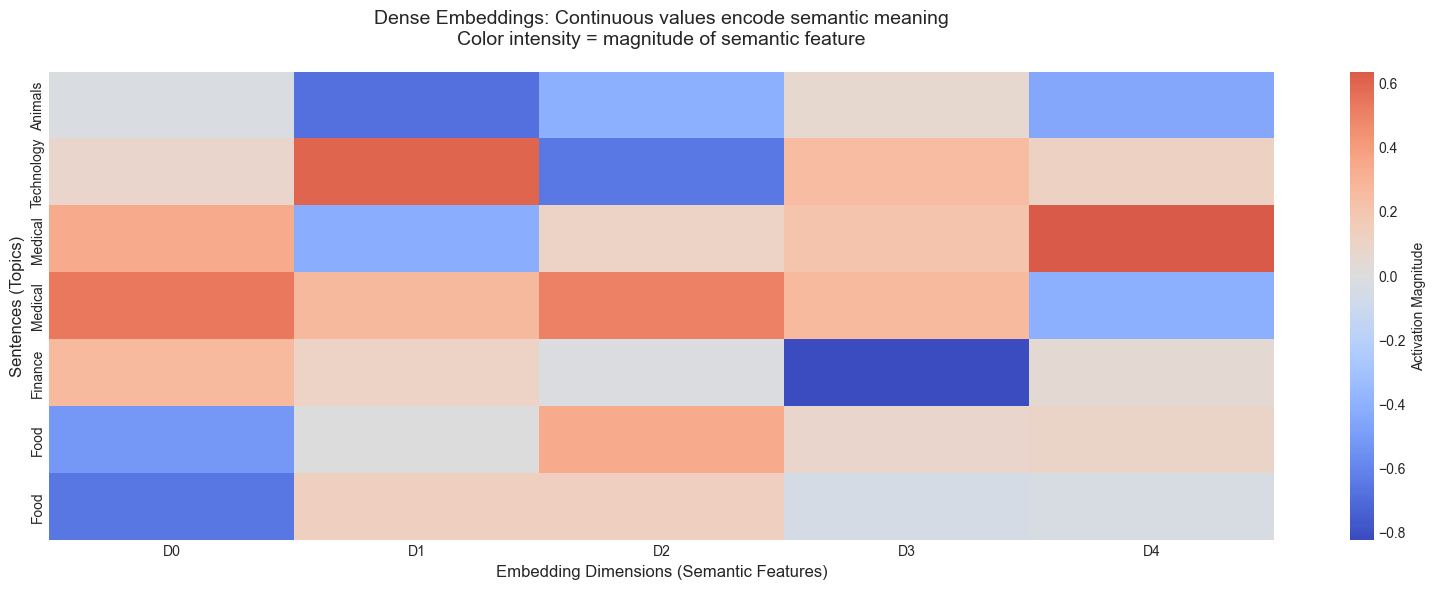


📊 What this shows:
  • Each row = one sentence embedded in 32 dimensions
  • Each column = a semantic feature dimension
  • Color intensity = how much that feature applies
  • Red = high positive value, Blue = high negative value
  • Similar topics may have similar patterns


In [12]:
print("=" * 80)
print("HEATMAP: Embedding Vectors (32 Dimensions)")
print("=" * 80)

# Create comprehensive heatmap
fig, ax = plt.subplots(figsize=(16, 6))

sns.heatmap(embeddings_32d, 
            cmap='coolwarm',
            center=0,
            xticklabels=[f'D{i}' for i in range(len(embeddings_32d[0]))],
            yticklabels=[f"{topic}" for topic in topics],
            cbar_kws={'label': 'Activation Magnitude'},
            ax=ax)

ax.set_xlabel('Embedding Dimensions (Semantic Features)', fontsize=12)
ax.set_ylabel('Sentences (Topics)', fontsize=12)
ax.set_title('Dense Embeddings: Continuous values encode semantic meaning\n' + 
             'Color intensity = magnitude of semantic feature', fontsize=14, pad=20)

plt.tight_layout()
plt.show()

print("\n📊 What this shows:")
print("  • Each row = one sentence embedded in 32 dimensions")
print("  • Each column = a semantic feature dimension")
print("  • Color intensity = how much that feature applies")
print("  • Red = high positive value, Blue = high negative value")
print("  • Similar topics may have similar patterns")

### 4.2 Semantic Similarity Analysis

Now let's see the magic: **similar meanings → similar vectors**

SEMANTIC SIMILARITY MATRIX


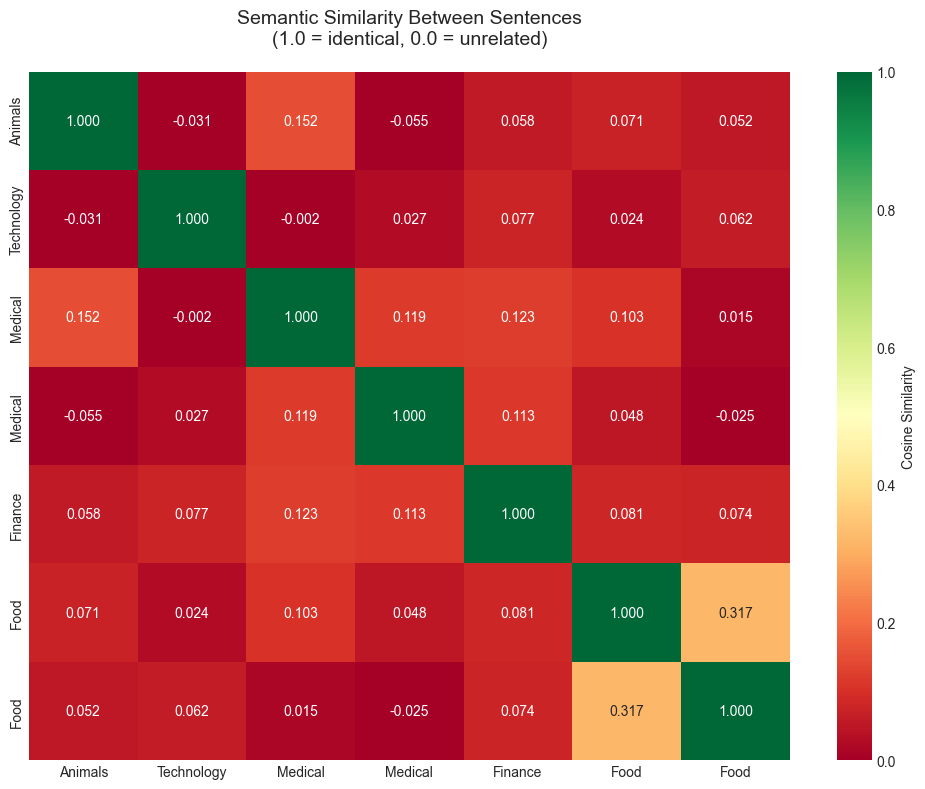


📊 Interpretation:
  • Diagonal = 1.0 (each sentence is identical to itself)
  • Higher values = more semantic similarity
  • Different topics have lower similarity
  • The model captures meaning, not just word overlap!


In [13]:
print("=" * 80)
print("SEMANTIC SIMILARITY MATRIX")
print("=" * 80)

# Calculate cosine similarity between all pairs
similarity_matrix = cosine_similarity(embeddings)

# Visualize similarity matrix
fig, ax = plt.subplots(figsize=(10, 8))

sns.heatmap(similarity_matrix, 
            annot=True, 
            fmt='.3f',
            cmap='RdYlGn',
            xticklabels=topics,
            yticklabels=topics,
            vmin=0, vmax=1,
            cbar_kws={'label': 'Cosine Similarity'},
            ax=ax)

ax.set_title('Semantic Similarity Between Sentences\n' +
             '(1.0 = identical, 0.0 = unrelated)', fontsize=14, pad=20)
plt.tight_layout()
plt.show()

print("\n📊 Interpretation:")
print("  • Diagonal = 1.0 (each sentence is identical to itself)")
print("  • Higher values = more semantic similarity")
print("  • Different topics have lower similarity")
print("  • The model captures meaning, not just word overlap!")

In [14]:
# Demonstrate semantic understanding
print("\n" + "=" * 80)
print("SEMANTIC UNDERSTANDING TEST")
print("=" * 80)

test_sentences = [
    "A dog is playing in the park",  # Similar to Animals
    "Artificial intelligence is changing the world",  # Similar to Technology
    "The nurse checked the vital signs",  # Similar to Medical
]

test_embeddings = st_model.encode(test_sentences)

print("\nTesting semantic similarity:\n")

for test_sent, test_emb in zip(test_sentences, test_embeddings):
    print(f"Query: '{test_sent}'\n")
    
    # Calculate similarity with all original sentences
    similarities = cosine_similarity([test_emb], embeddings)[0]
    
    # Find most similar
    most_similar_idx = np.argmax(similarities)
    
    print("Similarity scores:")
    for i, (topic, score) in enumerate(zip(topics, similarities)):
        marker = " ← MOST SIMILAR" if i == most_similar_idx else ""
        print(f"  {topic:12} {score:.3f} {'█' * int(score * 30)}{marker}")
    print()

print("\n✅ The embeddings understand semantic meaning!")
print("   Similar concepts have high similarity scores.")


SEMANTIC UNDERSTANDING TEST

Testing semantic similarity:

Query: 'A dog is playing in the park'

Similarity scores:
  Animals      0.107 ███ ← MOST SIMILAR
  Technology   0.045 █
  Medical      -0.087 
  Medical      -0.094 
  Finance      -0.025 
  Food         -0.073 
  Food         0.000 

Query: 'Artificial intelligence is changing the world'

Similarity scores:
  Animals      0.010 
  Technology   0.455 █████████████ ← MOST SIMILAR
  Medical      -0.043 
  Medical      -0.019 
  Finance      0.086 ██
  Food         0.056 █
  Food         -0.011 

Query: 'The nurse checked the vital signs'

Similarity scores:
  Animals      0.178 █████
  Technology   0.019 
  Medical      0.483 ██████████████ ← MOST SIMILAR
  Medical      0.225 ██████
  Finance      0.035 █
  Food         0.153 ████
  Food         0.009 


✅ The embeddings understand semantic meaning!
   Similar concepts have high similarity scores.


---

## Part 5: Embeddings with Mistral

Now let's use Mistral's embedding model to generate embeddings.

In [15]:
# Load Mistral API key
load_dotenv()
api_key = os.getenv("MISTRAL_API_KEY")

if not api_key:
    print("⚠️  Warning: MISTRAL_API_KEY not found in .env file")
    print("Please add your Mistral API key to continue with this section.")
else:
    mistral_client = Mistral(api_key=api_key)
    print("✓ Mistral client initialized!")

✓ Mistral client initialized!


In [16]:
print("=" * 80)
print("MISTRAL EMBEDDINGS")
print("=" * 80)

# Same 5 sentences
sentences_mistral = [
    "The cat sat on the mat and purred contentedly.",
    "Machine learning algorithms process vast amounts of data.",
    "The doctor examined the patient's symptoms carefully.",
    "The stock market experienced significant volatility today.",
    "The chef prepared a delicious Italian pasta dish."
]

print("\nGenerating Mistral embeddings...\n")

try:
    # Get embeddings from Mistral
    embeddings_response = mistral_client.embeddings.create(
        model="mistral-embed",
        inputs=sentences_mistral
    )
    
    # Extract embeddings
    mistral_embeddings = np.array([item.embedding for item in embeddings_response.data])
    
    print(f"✓ Generated Mistral embeddings!")
    print(f"Shape: {mistral_embeddings.shape}")
    print(f"  • {mistral_embeddings.shape[0]} sentences")
    print(f"  • {mistral_embeddings.shape[1]} dimensions per embedding")
    
    # Show sample values
    print(f"\nExample: First 10 dimensions of '{topics[0]}' embedding:")
    print(mistral_embeddings[0][:10])
    
except Exception as e:
    print(f"Error generating Mistral embeddings: {e}")
    print("Please check your API key and try again.")
    mistral_embeddings = None

MISTRAL EMBEDDINGS

Generating Mistral embeddings...

Error generating Mistral embeddings: [WinError 10054] An existing connection was forcibly closed by the remote host
Please check your API key and try again.


In [17]:
if mistral_embeddings is not None:
    print("\n" + "=" * 80)
    print("MISTRAL EMBEDDINGS - REDUCING TO 32D FOR VISUALIZATION")
    print("=" * 80)
    
    # Reduce dimensions for visualization
    pca_mistral = PCA(n_components=len(sentences_mistral))
    mistral_embeddings_32d = pca_mistral.fit_transform(mistral_embeddings)
    
    print(f"\nReduced from {mistral_embeddings.shape[1]}D to 32D")
    print(f"Variance explained: {pca_mistral.explained_variance_ratio_.sum():.2%}")
    
    # Visualize
    fig, ax = plt.subplots(figsize=(16, 6))
    
    sns.heatmap(mistral_embeddings_32d, 
                cmap='coolwarm',
                center=0,
                xticklabels=[f'D{i}' for i in range(len(sentences_mistral))],
                yticklabels=[f"{topic}" for topic in topics],
                cbar_kws={'label': 'Activation Magnitude'},
                ax=ax)
    
    ax.set_xlabel('Embedding Dimensions (Semantic Features)', fontsize=12)
    ax.set_ylabel('Sentences (Topics)', fontsize=12)
    ax.set_title('Mistral Embeddings: Dense semantic representation\n' + 
                 'Each dimension captures abstract semantic features', fontsize=14, pad=20)
    
    plt.tight_layout()
    plt.show()
    
    # Calculate similarity
    similarity_matrix_mistral = cosine_similarity(mistral_embeddings)
    
    # Visualize similarity
    fig, ax = plt.subplots(figsize=(10, 8))
    
    sns.heatmap(similarity_matrix_mistral, 
                annot=True, 
                fmt='.3f',
                cmap='RdYlGn',
                xticklabels=topics,
                yticklabels=topics,
                vmin=0, vmax=1,
                cbar_kws={'label': 'Cosine Similarity'},
                ax=ax)
    
    ax.set_title('Mistral Embeddings: Semantic Similarity Matrix', fontsize=14, pad=20)
    plt.tight_layout()
    plt.show()
    
    print("\n✅ Mistral embeddings also capture semantic meaning!")

---

## Part 6: Comparison Summary

Let's compare all the encoding methods we've explored.

In [18]:
print("=" * 80)
print("ENCODING METHODS COMPARISON")
print("=" * 80)

comparison_df = pd.DataFrame({
    'Method': [
        'Binary Encoding',
        'One-Hot Encoding',
        'Multi-Hot (BoW)',
        'Dense Embeddings'
    ],
    'Dimensions': [
        'log₂(vocab_size)',
        'vocab_size (10K-100K)',
        'vocab_size (10K-100K)',
        'Fixed (384-1536)'
    ],
    'Sparsity': [
        'Dense',
        'Extremely sparse',
        'Very sparse',
        'Dense'
    ],
    'Semantic Info': [
        'None',
        'None',
        'None',
        'Rich'
    ],
    'Similar Words': [
        'No relationship',
        'All equally distant',
        'All equally distant',
        'Close in space'
    ],
    'Use Case': [
        'Simple identifiers only',
        'Simple classification',
        'Document classification',
        'RAG, semantic search, AI'
    ]
})

print("\n")
print(comparison_df.to_string(index=False))
print("\n" + "=" * 80)

ENCODING METHODS COMPARISON


          Method            Dimensions         Sparsity Semantic Info       Similar Words                 Use Case
 Binary Encoding      log₂(vocab_size)            Dense          None     No relationship  Simple identifiers only
One-Hot Encoding vocab_size (10K-100K) Extremely sparse          None All equally distant    Simple classification
 Multi-Hot (BoW) vocab_size (10K-100K)      Very sparse          None All equally distant  Document classification
Dense Embeddings      Fixed (384-1536)            Dense          Rich      Close in space RAG, semantic search, AI



---

## Part 7: Key Takeaways

### 🎯 Understanding Embeddings

1. **Tokenization** breaks text into processable units
2. **Binary/One-Hot Encoding** uses dimensions as discrete identifiers
   - Simple but limited
   - No semantic information
   - High dimensional and sparse

3. **Dense Embeddings** use continuous numbers to encode semantics
   - Each dimension = a learned semantic feature
   - Magnitude = how much that feature applies
   - Similar meanings → similar vectors
   - Lower dimensional (384-1536D vs 10K-100K)

### 🔑 Why Dense Embeddings are Revolutionary

- **Semantic Understanding**: "king" - "man" + "woman" ≈ "queen"
- **Efficient**: 384 meaningful dimensions vs 50,000 sparse ones
- **Scalable**: Works for words, sentences, paragraphs, documents
- **Universal**: Same embedding space for different texts
- **Foundational**: Powers RAG, semantic search, and modern AI

### 🚀 Applications

1. **Semantic Search**: Find documents by meaning, not keywords
2. **RAG**: Retrieve relevant context for LLMs
3. **Clustering**: Group similar documents
4. **Recommendation**: Find similar items
5. **Classification**: Categorize based on meaning

### 📚 Models for Production

**Open Source (Sentence Transformers):**
- `all-MiniLM-L6-v2`: Fast, 384 dimensions
- `all-mpnet-base-v2`: High quality, 768 dimensions
- `multi-qa-mpnet-base-dot-v1`: Optimized for Q&A

**Commercial:**
- Mistral Embed: 1024 dimensions
- OpenAI `text-embedding-3-small/large`
- Cohere Embed

### 🎓 Mathematical Foundation

**Cosine Similarity**: Measures how similar two vectors are
```
similarity = (A · B) / (||A|| × ||B||)
```
- Range: -1 to 1 (or 0 to 1 for normalized vectors)
- Higher values = more similar meanings
- Foundation of semantic search

---

## Next Steps

Now that you understand embeddings, you're ready to:
1. Build semantic search systems
2. Implement RAG pipelines
3. Create vector databases
4. Build AI applications with semantic understanding

**Embeddings are the bridge between human language and machine understanding!** 🌉